# 基本信息

In [1]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score,precision_recall_curve,roc_curve
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,KFold,GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures,OneHotEncoder,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from tensorflow import keras
import graphviz
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
import random

sns.set(style="white", color_codes=True)
#显示所有列
pd.set_option('display.max_columns', None)
#取消科学计数，显示小数点后1位
pd.set_option('float_format', lambda x: '%.1f' % x)
# pd.set_option('display.max_rows', None)
seed = 100
np.random.seed(seed)
random.seed(seed)

In [15]:
trainfile = '../data/train.csv'
train_data = pd.read_csv(trainfile)
print("rows:",train_data.shape[0]," columns:", train_data.shape[1])

rows: 1521787  columns: 23


In [16]:
testfile = '../data/test.csv'
test_data = pd.read_csv(testfile)
print("rows:",test_data.shape[0]," columns:", test_data.shape[1])

rows: 421665  columns: 22


In [17]:
# 改时间为小时
def change_time(data):
    time = data['loctm']
    newtime = []
    for i in time:
        k = int(i/10000)
        newtime.append(k)
    data['loctm'] = newtime

In [18]:
change_time(train_data)
change_time(test_data)

In [ ]:
cat_cols =  list(train_data.columns)
cat_cols.remove('fraud_ind')
cat_cols.remove('txkey')
cat_cols.remove('loctm')
cat_cols.remove('locdt')
cat_cols.remove('conam')
for col in cat_cols:
    if col in train_data.columns:
        le = LabelEncoder()
        le.fit(list(train_data[col].astype(str).values) + list(test_data[col].astype(str).values))
        train_data[col] = le.transform(list(train_data[col].astype(str).values))
        test_data[col] = le.transform(list(test_data[col].astype(str).values)) 

In [19]:
train_data = train_data.replace(['N','Y'],[0,1])
test_data = test_data.replace(['N','Y'],[0,1])

In [20]:
# features interaction 并使用 labelencoder
cb_feature = ['bacno__cano','mcc__mchno','stocn__scity','stocn__csmcu','csmcu__acqic','etymd__csmcu','mcc__csmcu',
                'stocn__ecfg','mcc__etymd','mcc__scity','stocn__acqic','scity__acqic','mcc__stocn','mcc__acqic','ecfg__stscd',
                'scity__ecfg','mcc__ecfg','etymd__ecfg','cano__mchno']
for feature in cb_feature:
    f1,f2 = feature.split('__')
    train_data[feature] = train_data[f1].astype(str) + '_' + train_data[f2].astype(str)
    test_data[feature] = test_data[f1].astype(str) + '_' + test_data[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train_data[feature].astype(str).values) + list(test_data[feature].astype(str).values))
    train_data[feature] = le.transform(list(train_data[feature].astype(str).values))
    test_data[feature] = le.transform(list(test_data[feature].astype(str).values))
    
# train_data['acqic_stocn_scity_mcc_mchno'] = train_data['acqic'].astype(str) + '_' + train_data['stocn'].astype(str)+ '_' + train_data['scity'].astype(str)+ '_' + train_data['mcc'].astype(str)+ '_' + train_data['mchno'].astype(str)
# test_data['acqic_stocn_scity_mcc_mchno'] = test_data['acqic'].astype(str) + '_' + test_data['stocn'].astype(str)+ '_' + test_data['scity'].astype(str)+ '_' + test_data['mcc'].astype(str)+ '_' + test_data['mchno'].astype(str)

# le = LabelEncoder()
# le.fit(list(train_data['acqic_stocn_scity_mcc_mchno'].astype(str).values) + list(test_data['acqic_stocn_scity_mcc_mchno'].astype(str).values))
# train_data['acqic_stocn_scity_mcc_mchno'] = le.transform(list(train_data['acqic_stocn_scity_mcc_mchno'].astype(str).values))
# test_data['acqic_stocn_scity_mcc_mchno'] = le.transform(list(test_data['acqic_stocn_scity_mcc_mchno'].astype(str).values))

In [21]:
# Count Encoding 
cn_feature = ['acqic','bacno','cano','scity','mchno','conam','mcc','csmcu',
            'mcc__mchno','stocn__scity','stocn__csmcu','csmcu__acqic','stocn__ecfg','mcc__etymd',
            'mcc__scity','mcc__stocn','mcc__acqic','scity__ecfg','mcc__csmcu','stocn__acqic','scity__acqic','ecfg__stscd',
             'cano__mchno',]
for feature in cn_feature:
    train_data[feature + '_count_full'] = train_data[feature].map(pd.concat([train_data[feature], test_data[feature]], ignore_index=True).value_counts(dropna=False))
    test_data[feature + '_count_full'] = test_data[feature].map(pd.concat([train_data[feature], test_data[feature]], ignore_index=True).value_counts(dropna=False))

In [23]:
# Group by  \ train_test 需合并？
train_test = train_data.append(test_data)
for uid in ['bacno__cano','cano__mchno']:
    for feature in ['acqic','csmcu','conam','loctm','ecfg','etymd','mcc','mchno','stocn','scity','stscd']:
        col_mean = train_test.groupby(uid)[feature].mean()
        train_data[feature + '_to_mean_' + uid] = train_data[uid].map(col_mean)
        test_data[feature + '_to_mean_' + uid] = test_data[uid].map(col_mean)
              
        col_std = train_test.groupby(uid)[feature].std()
        train_data[feature + '_to_std_' + uid] = train_data[uid].map(col_std)
        test_data[feature + '_to_std_' + uid] = test_data[uid].map(col_std)
    
#     train_data['conam_devide_mean_' + feature] = train_data['conam']/ train_data.groupby([feature])['conam'].transform('mean')
#     test_data['conam_devide_mean_' + feature] = test_data['conam'] / test_data.groupby([feature])['conam'].transform('mean')

In [ ]:
test_data

In [ ]:
# # 删除只出现过1次的商店和只消费过1次的卡。
# data_new = data_df.groupby(['acqic','stocn','scity','mcc','mchno']).filter(lambda x: (len(x) > 1))
# data_new = data_new.groupby(['bacno','cano']).filter(lambda x: (len(x) > 1))
# data_new = data_new.reset_index()
# data_new.shape

In [ ]:
# # 指定分类特征
# category_col = ['acqic','bacno','cano','stocn','scity','mcc','csmcu','ecfg','etymd','stscd']
# for col in category_col:
#     train_data[col] = train_data[col].astype('category')
#     test_data[col] = test_data[col].astype('category')

In [36]:
model1_features = list(train_data.columns)
del_col = ['bacno','cano','contp','flbmk','flg_3dsmk','hcefg','insfg','iterm','ovrlt','txkey','locdt','fraud_ind','stocn__scity','mcc__csmcu',
             'stocn__ecfg','mcc__acqic','scity__ecfg','mcc__etymd','etymd__ecfg','bacno__cano','cano__mchno']
for col in del_col:
    model1_features.remove(col)
    
X_train = train_data[model1_features]
Y_train = train_data['fraud_ind']
X_test = test_data[model1_features]
print(X_train.shape,X_test.shape)
print(X_train.info())

(1521787, 88) (421665, 88)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521787 entries, 0 to 1521786
Data columns (total 88 columns):
acqic                        1521787 non-null int64
conam                        1521787 non-null float64
csmcu                        1521787 non-null int64
ecfg                         1521787 non-null int64
etymd                        1521787 non-null int64
loctm                        1521787 non-null int64
mcc                          1521787 non-null int64
mchno                        1521787 non-null int64
scity                        1521787 non-null int64
stocn                        1521787 non-null int64
stscd                        1521787 non-null int64
mcc__mchno                   1521787 non-null int64
stocn__csmcu                 1521787 non-null int64
csmcu__acqic                 1521787 non-null int64
etymd__csmcu                 1521787 non-null int64
mcc__scity                   1521787 non-null int64
stocn__acqic              

In [ ]:
# x_train,x_valid,y_train,y_valid = train_test_split(data_train,data_label,test_size = 0.2,random_state=666)
# print(x_train.shape,y_train.shape)
# print(x_valid.shape,y_valid.shape)

In [ ]:
# smoee = SMOTE(random_state = 666)
# data_train_up,data_label_up = smoee.fit_sample(data_train,data_label)
# print(data_train_up.shape,data_label_up.shape)

In [37]:
params = {'num_leaves': 499,
          'min_child_weight': 0.009009297771374483,
          'feature_fraction': 0.8931730501715401,
          'bagging_fraction': 0.8249551970384116,
          'min_data_in_leaf': 120,
          'objective': 'binary',
          'max_depth': 47,
          'learning_rate': 0.1,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 1.1690935357787136,
          'reg_lambda': 1.119698800271026,
          'is_unbalance': True,
          'random_state': seed,  
          'device': 'cpu',
         }

In [39]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

splits = 3
# folds = KFold(n_splits = splits, shuffle=True, random_state=seed)
folds = GroupKFold(n_splits = splits)
split_groups = train_data['locdt']

oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, Y_train.values,groups=split_groups)):
    print("Fold {}".format(fold_))
    train_df, train_lb = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
    valid_df, valid_lb = X_train.iloc[val_idx], Y_train.iloc[val_idx]
    
    trn_data = lgb.Dataset(train_df, label=train_lb)
    val_data = lgb.Dataset(valid_df, label=valid_lb)
    
    clf = lgb.train(params,
                    trn_data,
                    num_boost_round= 5000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=200,
                    early_stopping_rounds = 200)
    
    valid_pre = clf.predict(valid_df)
    oof[val_idx] = valid_pre
    feature_importances['fold_{}'.format(fold_ + 1)] = clf.feature_importance()
    predictions += clf.predict(X_test) / splits  
    print(predictions[:5])
    print("-"*100,'\r\n')

print("auc_oof:",roc_auc_score(Y_train,oof))


Fold 0
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.999994	valid_1's auc: 0.983593
[400]	training's auc: 0.999997	valid_1's auc: 0.984228
[600]	training's auc: 0.999997	valid_1's auc: 0.984248
[800]	training's auc: 0.999997	valid_1's auc: 0.984293
Early stopping, best iteration is:
[769]	training's auc: 0.999997	valid_1's auc: 0.984382
[4.28767071e-05 4.79652945e-05 1.00096216e-05 1.24379214e-05
 4.28767071e-05]
---------------------------------------------------------------------------------------------------- 

Fold 1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.999995	valid_1's auc: 0.978176
[400]	training's auc: 0.999997	valid_1's auc: 0.97913
[600]	training's auc: 0.999998	valid_1's auc: 0.979342
Early stopping, best iteration is:
[518]	training's auc: 0.999997	valid_1's auc: 0.979354
[0.0013895  0.00078522 0.00013663 0.00011294 0.0013895 ]
------------------------------------------------------------

last_oof_auc:  0.9831946161918341


<function matplotlib.pyplot.show(*args, **kw)>

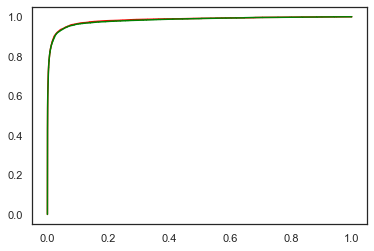

In [40]:
oof_file_path = '../result/compare.csv'
last_oof = np.array(pd.read_csv(oof_file_path))
print('last_oof_auc: ',roc_auc_score(Y_train,last_oof))

# ROC 曲线对比
l_fpr,l_tpr,l_t = roc_curve(Y_train,last_oof)
fpr,tpr,t = roc_curve(Y_train,oof)
plt.plot(l_fpr,l_tpr,color='red')
plt.plot(fpr,tpr,color='green')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

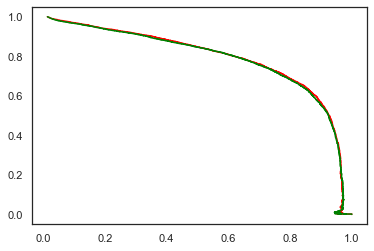

In [41]:
# PR 曲线对比
l_pr,l_re,l_t = precision_recall_curve(Y_train,last_oof)
pr,re,t = precision_recall_curve(Y_train,oof)
plt.plot(l_pr,l_re,color='red')
plt.plot(pr,re,color='green')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

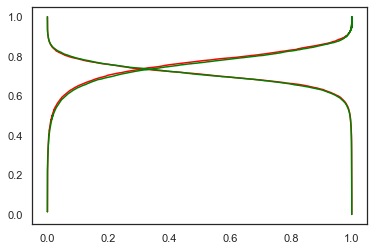

In [42]:
plt.plot(l_t,l_pr[:-1],color='red')
plt.plot(l_t,l_re[:-1],color='red')
plt.show
plt.plot(t,pr[:-1],color='green')
plt.plot(t,re[:-1],color='green')
plt.show

In [43]:
# 获取最佳 阈值方法 
def get_threshold(pre,rec,threshold):
    thold = []
    for i in range(len(threshold)):
        if round(pre[i],4)== round(rec[i],4):
            thold.append(threshold[i]) 
    return thold

In [44]:
# 用最佳阀值 比较两次f1差别
l_pr,l_re,l_t = precision_recall_curve(Y_train,last_oof)
pr,re,t = precision_recall_curve(Y_train,oof)
l_thold = get_threshold(l_pr,l_re,l_t)
thold = get_threshold(pr,re,t)
oof_last_pre = [int(item>l_thold[0]) for  item in last_oof]
oof_pre = [int(item>thold[0]) for  item in oof]
print('last_f1:',f1_score(Y_train,oof_last_pre)," threshold:",l_thold)
print('f1:',f1_score(Y_train,oof_pre)," threshold:",thold)

last_f1: 0.7356914762957504  threshold: [0.31122656884830635, 0.3114257617468866, 0.3114739956888668]
f1: 0.7348252229236778  threshold: [0.3374391956437427, 0.33767247550063717, 0.33796346480857686]


In [45]:
# 0.5阀值 比较两次f1差别
oof_last_pre = [int(item>0.5) for  item in last_oof]
oof_pre = [int(item>0.54) for  item in oof]
print('last_f1:',f1_score(Y_train,oof_last_pre)," threshold:",l_thold)
print('f1:',f1_score(Y_train,oof_pre)," threshold:",thold)

last_f1: 0.7417385057471266  threshold: [0.31122656884830635, 0.3114257617468866, 0.3114739956888668]
f1: 0.7363891680193759  threshold: [0.3374391956437427, 0.33767247550063717, 0.33796346480857686]


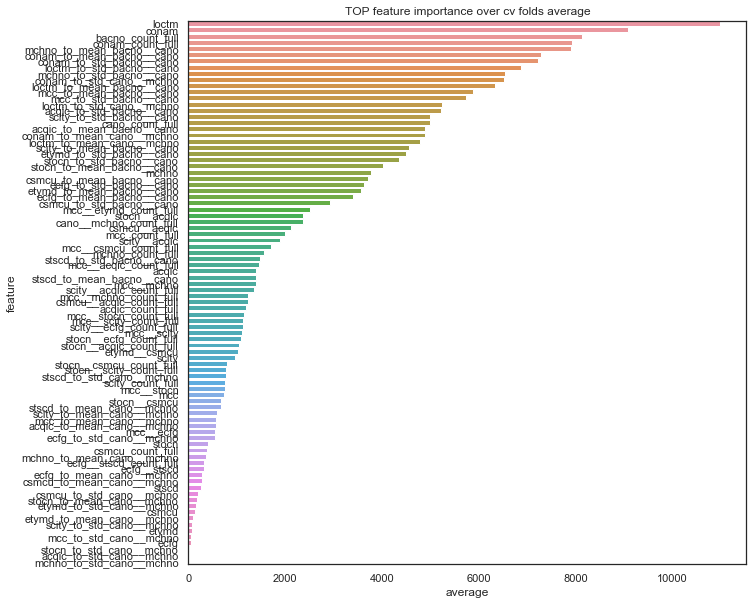

In [47]:
feature_importances['average'] = feature_importances.mean(axis=1)
plt.figure(figsize=(10, 10))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(100), x='average', y='feature')
plt.title('TOP feature importance over cv folds average');

# debug记录oof

In [38]:
'''是否将oof存为新指标'''
print("save oof file...")
last_oof = pd.DataFrame({'oof':oof})
last_oof.to_csv('../result/compare.csv',index=None)

save oof file...


# 预测阶段

In [35]:
# pr,re,t = precision_recall_curve(Y_train,oof)
# threshold = get_threshold(pr,re,t)[0]
# print(threshold)
# 结果保存
predict = [int(item>0.5) for  item in predictions]
result_file_path = '../data/submission_test.csv'
result_data = pd.read_csv(result_file_path)
result_data['fraud_ind'] = predict
result_data.to_csv('../result/submission_test.csv',index=None)

In [ ]:
predictions[:5]

In [ ]:
splits = 3
folds = GroupKFold(n_splits = splits)
split_groups = train_data['locdt']

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, Y_train.values,groups=split_groups)):
    print("Fold {}".format(fold_))
    train_df, train_lb = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
    valid_df, valid_lb = X_train.iloc[val_idx], Y_train.iloc[val_idx]
    
    print(valid_lb.sum())
    print(split_groups[val_idx].value_counts())
